In [247]:
import xgboost as xgb
import holidays
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [248]:
df = pd.read_csv('data/2yrs_data.csv')
df

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...,...,...
1070561,2008-12-31,23:55:00,0.484,0.064,247.69,2.2,0.0,0.0,0.0
1070562,2008-12-31,23:56:00,0.482,0.064,247.35,2.2,0.0,0.0,0.0
1070563,2008-12-31,23:57:00,0.482,0.064,246.99,2.2,0.0,0.0,0.0
1070564,2008-12-31,23:58:00,0.480,0.064,246.52,2.2,0.0,0.0,0.0


# Feature Engineering

In [249]:
df['Date'] = pd.to_datetime(df['Date'])
df['is_weekend'] = df['Date'].dt.weekday.isin([5, 6]).astype(int)
df

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,is_weekend
0,2006-12-16,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,1
1,2006-12-16,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,1
2,2006-12-16,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,1
3,2006-12-16,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,1
4,2006-12-16,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,1
...,...,...,...,...,...,...,...,...,...,...
1070561,2008-12-31,23:55:00,0.484,0.064,247.69,2.2,0.0,0.0,0.0,0
1070562,2008-12-31,23:56:00,0.482,0.064,247.35,2.2,0.0,0.0,0.0,0
1070563,2008-12-31,23:57:00,0.482,0.064,246.99,2.2,0.0,0.0,0.0,0
1070564,2008-12-31,23:58:00,0.480,0.064,246.52,2.2,0.0,0.0,0.0,0


In [250]:
fr_holidays = holidays.France(years=range(2006, 2010))
df['is_holiday'] = df['Date'].isin(fr_holidays).astype(int)

df

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,is_weekend,is_holiday
0,2006-12-16,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,1,0
1,2006-12-16,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,1,0
2,2006-12-16,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,1,0
3,2006-12-16,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,1,0
4,2006-12-16,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
1070561,2008-12-31,23:55:00,0.484,0.064,247.69,2.2,0.0,0.0,0.0,0,0
1070562,2008-12-31,23:56:00,0.482,0.064,247.35,2.2,0.0,0.0,0.0,0,0
1070563,2008-12-31,23:57:00,0.482,0.064,246.99,2.2,0.0,0.0,0.0,0,0
1070564,2008-12-31,23:58:00,0.480,0.064,246.52,2.2,0.0,0.0,0.0,0,0


In [251]:
df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.hour  
df['Minute'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.minute 
df['Day'] = pd.to_datetime(df['Date']).dt.day                      
df['Month'] = pd.to_datetime(df['Date']).dt.month                 
df['Year'] = pd.to_datetime(df['Date']).dt.year  

df['hourly_active_power'] = df.groupby(['Year','Month','Day','Hour'])['Global_active_power'].transform('sum')

scaler = MinMaxScaler(feature_range=(0, 1))
df['hourly_active_power'] = scaler.fit_transform(df[['hourly_active_power']])

df = df.drop(columns=['Date', 'Time','Minute','Global_active_power','Global_reactive_power','Global_intensity','Voltage','Sub_metering_1','Sub_metering_2','Sub_metering_3'],).reset_index()
df = df.drop(columns=['index']).drop_duplicates().reset_index(drop=True)
df



,is_weekend,is_holiday,Hour,Day,Month,Year,hourly_active_power
0,1,0,17,16,12,2006,0.379656
1,1,0,18,16,12,2006,0.548879
2,1,0,19,16,12,2006,0.513143
3,1,0,20,16,12,2006,0.492860
4,1,0,21,16,12,2006,0.460185
...,...,...,...,...,...,...,...
17844,0,0,19,31,12,2008,0.475061
17845,0,0,20,31,12,2008,0.633110
17846,0,0,21,31,12,2008,0.301329
17847,0,0,22,31,12,2008,0.150516


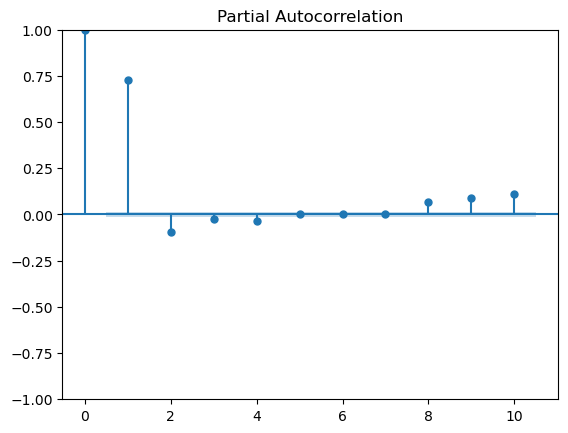

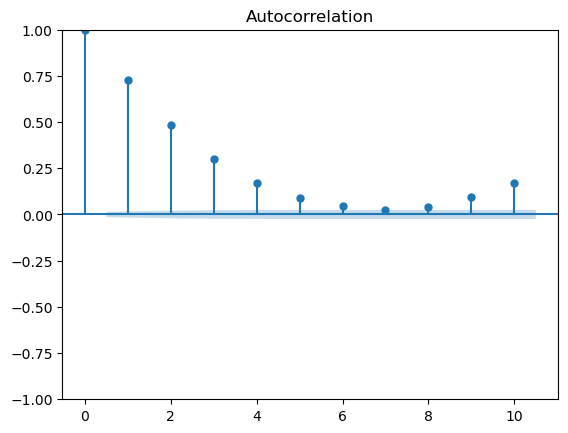

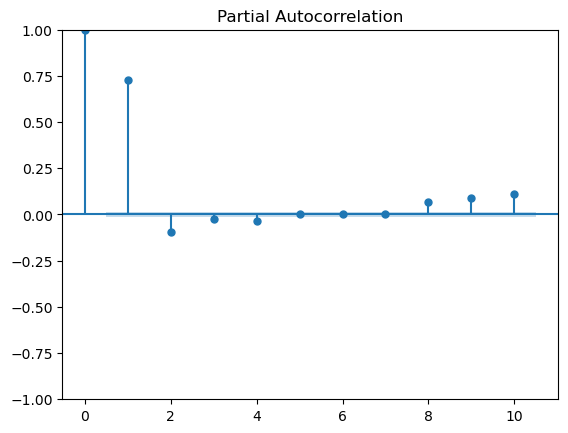

In [252]:
plot_acf(df['hourly_active_power'], lags=10)
plot_pacf(df['hourly_active_power'], lags=10)

In [253]:
N_LAGS = 2  # Number of lag features to create
for lag in range(1, N_LAGS + 1):
    df[f'lag_{lag}'] = df['hourly_active_power'].shift(lag)


df['rolling_mean_2'] = df['hourly_active_power'].rolling(window=2).mean()
df['rolling_std_2'] = df['hourly_active_power'].rolling(window=2).std()

df.dropna(inplace=True)

df

,is_weekend,is_holiday,Hour,Day,Month,Year,hourly_active_power,lag_1,lag_2,rolling_mean_2,rolling_std_2
2,1,0,19,16,12,2006,0.513143,0.548879,0.379656,0.531011,0.025269
3,1,0,20,16,12,2006,0.492860,0.513143,0.548879,0.503001,0.014343
4,1,0,21,16,12,2006,0.460185,0.492860,0.513143,0.476522,0.023105
5,1,0,22,16,12,2006,0.328263,0.460185,0.492860,0.394224,0.093283
6,1,0,23,16,12,2006,0.306922,0.328263,0.460185,0.317592,0.015091
...,...,...,...,...,...,...,...,...,...,...,...
17844,0,0,19,31,12,2008,0.475061,0.258200,0.228688,0.366630,0.153344
17845,0,0,20,31,12,2008,0.633110,0.475061,0.258200,0.554086,0.111758
17846,0,0,21,31,12,2008,0.301329,0.633110,0.475061,0.467220,0.234604
17847,0,0,22,31,12,2008,0.150516,0.301329,0.633110,0.225923,0.106641


# Model trianing

In [254]:
train_size = int(len(df) * 0.8)  # 80% for training
train = df.iloc[:train_size]
test = df.iloc[train_size:]

X_train = train.drop('hourly_active_power', axis=1)  # Features
y_train = train['hourly_active_power']               # Target
X_test = test.drop('hourly_active_power', axis=1)    # Features
y_test = test['hourly_active_power']                 # Target

In [255]:
train_dmatrix = xgb.DMatrix(X_train, label=y_train)
# val_dmatrix = xgb.DMatrix(X_val, label=y_val)
test_dmatrix = xgb.DMatrix(X_test, label=y_test)

In [256]:
params = {
    'objective': 'reg:squarederror',  # Regression problem
    'max_depth': 20,                  # Tree depth
    'eta': 0.01,                      # Learning rate
    'seed': 42
}

evals_result = {}

model = xgb.train(params, 
                  train_dmatrix, 
                  num_boost_round=1000,
                  evals=[(train_dmatrix, 'train'), (test_dmatrix, 'test')],
                  evals_result=evals_result,
                  early_stopping_rounds=10,  # Stop if no improvement after 10 rounds
                  verbose_eval=False)
y_pred = model.predict(test_dmatrix)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r_squared = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R-squared: {r_squared:.4f}")

RMSE: 0.0077
R-squared: 0.9970


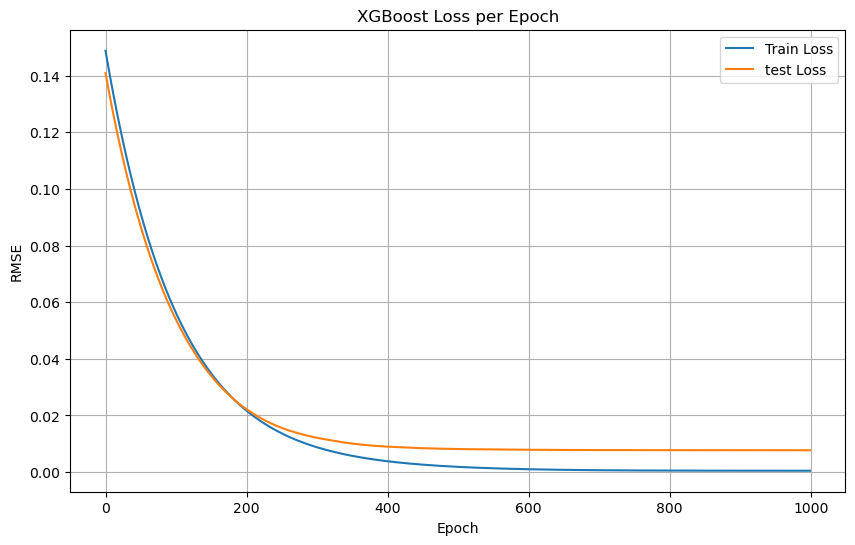

In [257]:
# Plot training and validation loss
epochs = len(evals_result['train']['rmse'])  # Number of epochs
x_axis = range(epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, evals_result['train']['rmse'], label='Train Loss')
plt.plot(x_axis, evals_result['test']['rmse'], label='test Loss')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('XGBoost Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

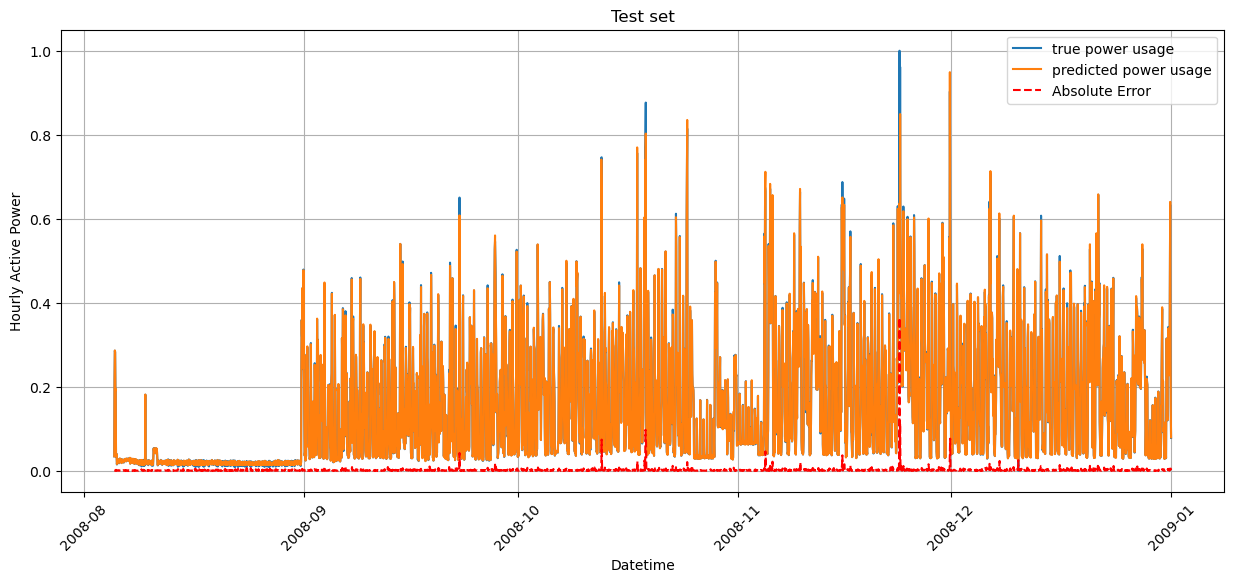

In [258]:
X_test['datetime'] = pd.to_datetime(X_test[['Year', 'Month', 'Day', 'Hour']])
error = np.abs(y_test - y_pred) 

plt.figure(figsize=(15, 6))
plt.plot(X_test['datetime'],y_test,  linestyle='-',label = 'true power usage')
plt.plot(X_test['datetime'],y_pred,  linestyle='-', label = 'predicted power usage')
plt.plot(X_test['datetime'], error, label='Absolute Error', color='red', linestyle='--')
plt.title('Test set')
plt.xlabel('Datetime')
plt.ylabel('Hourly Active Power')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.show()

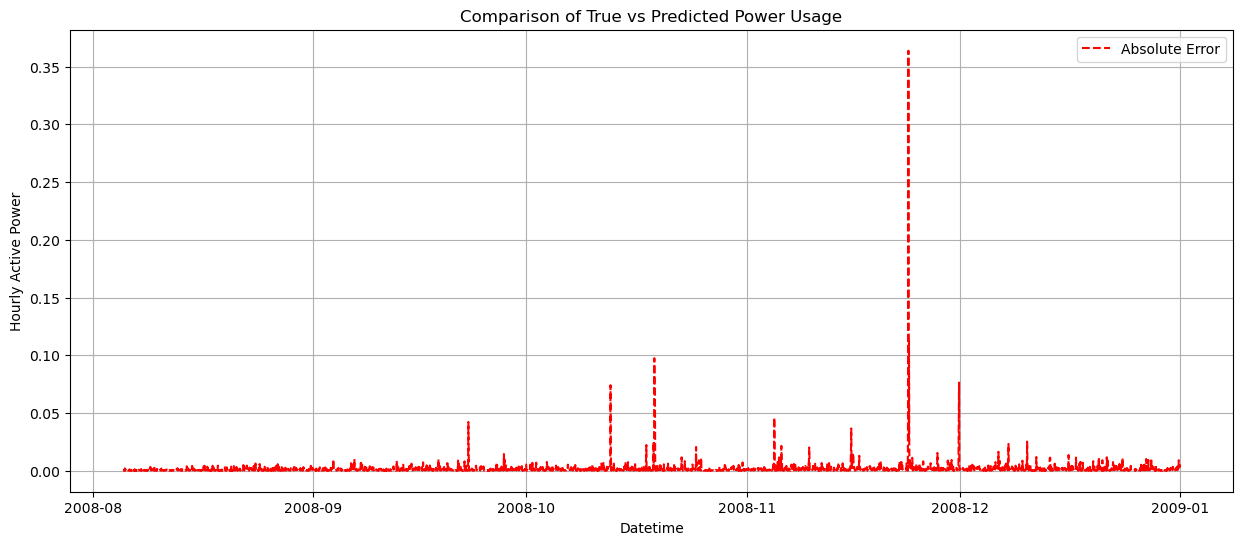

In [259]:
error = np.abs(y_test - y_pred) 

plt.figure(figsize=(15, 6))
plt.plot(X_test['datetime'], error, label='Absolute Error', color='red', linestyle='--')
plt.title('Comparison of True vs Predicted Power Usage')
plt.xlabel('Datetime')
plt.ylabel('Hourly Active Power')
plt.legend()
plt.grid(True)
plt.show()